<a href="https://colab.research.google.com/github/SergeyShchus/OSM/blob/main/Notebook/OSMX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx

In [2]:
import geopandas as gpd
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

In [3]:
# turn response caching off
ox.config(use_cache=False)

# turn it back on and turn on/off logging to your console
ox.config(use_cache=True, log_console=False)

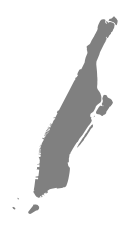

In [4]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan, New York, USA")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

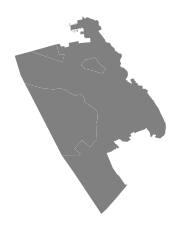

In [11]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [12]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["R2192363", "N240109189", "W427818536"], by_osmid=True)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"MULTIPOLYGON (((12.45300 55.71222, 12.45309 55...",55.732703,55.612861,12.734246,12.453000,282316735,relation,2192363,55.655547,12.601643,"Copenhagen Municipality, Capital Region of Den...",boundary,administrative,0.495253
1,POINT (13.38886 52.51704),52.677036,52.357036,13.548860,13.228860,567505,node,240109189,52.517037,13.388860,"Berlin, 10117, Germany",place,city,0.787539
2,"POLYGON ((-73.98141 40.76846, -73.98135 40.768...",40.800314,40.764745,-73.949606,-73.981408,198300704,way,427818536,40.782773,-73.965363,"Central Park, New York County, New York, Unite...",leisure,park,0.565172


# Method #1, pass a bounding box
This constructs the network from all the OSM nodes and ways within the bounding box.

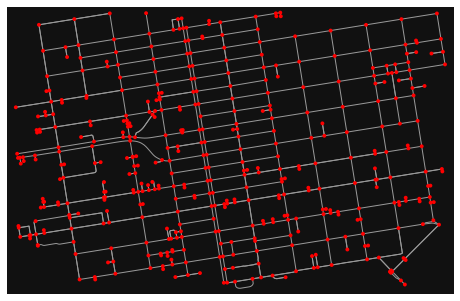

In [19]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
fig, ax = ox.plot_graph(G, node_color="r")

# Method #2, pass a lat-lng point and bounding box distance in meters
This creates a bounding box n meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

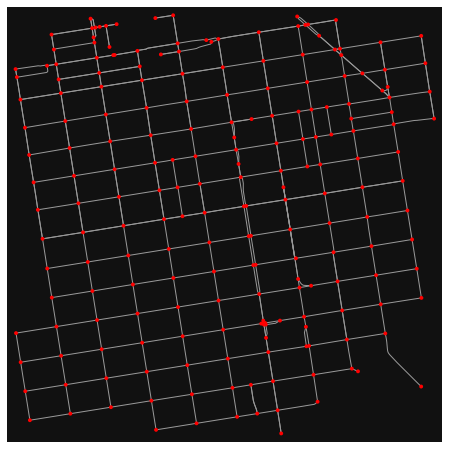

In [24]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(G, node_color="r")

# Method #3, pass a lat-lng point and network distance in meters
This creates a bounding box n meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than n meters from the point along the network.



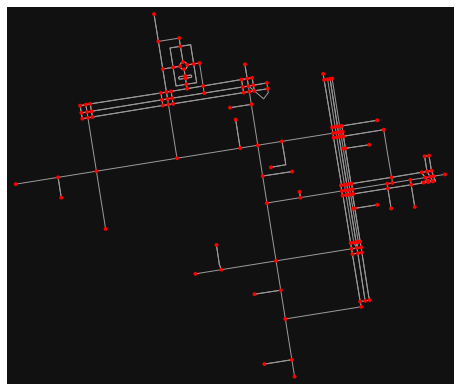

In [23]:
# same point again, but create network only of nodes within 500m along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network")
fig, ax = ox.plot_graph(G, node_color="r")

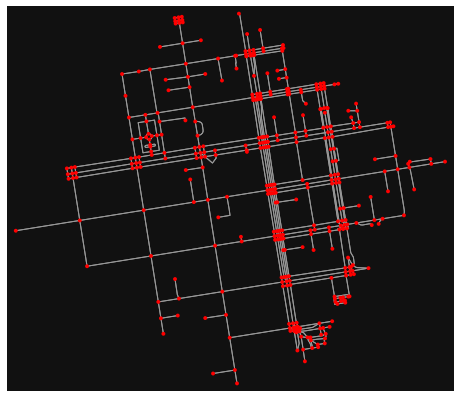

In [25]:
# create network only of nodes within 500m walking along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network", network_type="walk")
fig, ax = ox.plot_graph(G, node_color="r")

# Method #4, pass an address and distance (bounding box or network) in meters
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

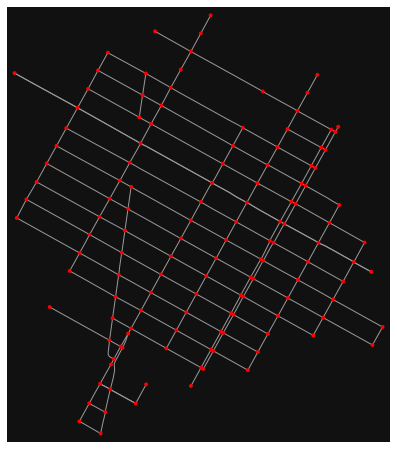

In [27]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

# Method #5, pass a place name
This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

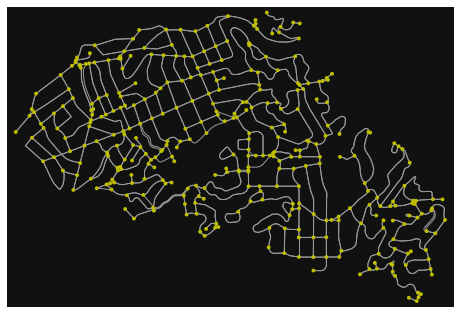

In [29]:
# create the street network within the city of Piedmont's borders
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
fig, ax = ox.plot_graph(G, node_color="y")

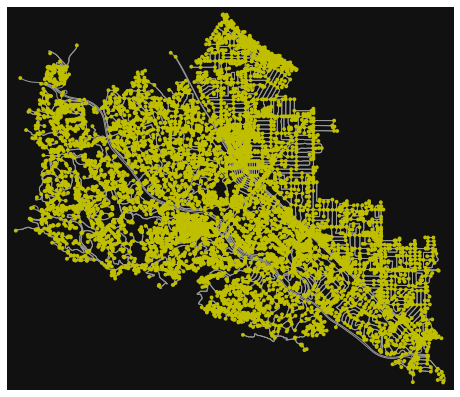

In [31]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, truncate_by_edge=True)
fig, ax = ox.plot_graph(G, node_color="y")

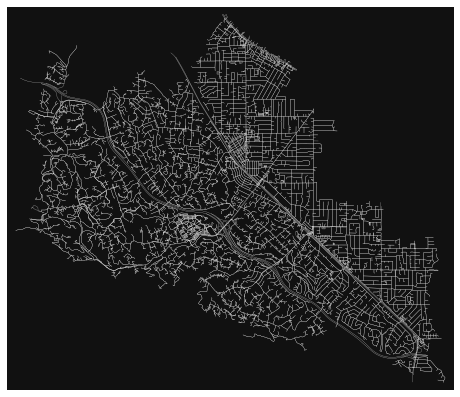

In [32]:
# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

# Method #6, pass a polygon
This example loads the Mission District's polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [ ]:
calif = gpd.read_file("input_data/ZillowNeighborhoods-CA")
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")

------------------------------------

In [34]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)

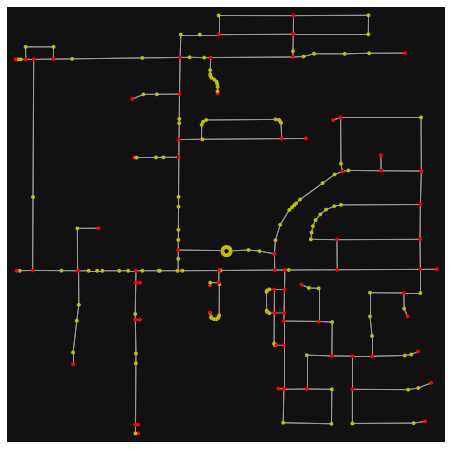

In [35]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

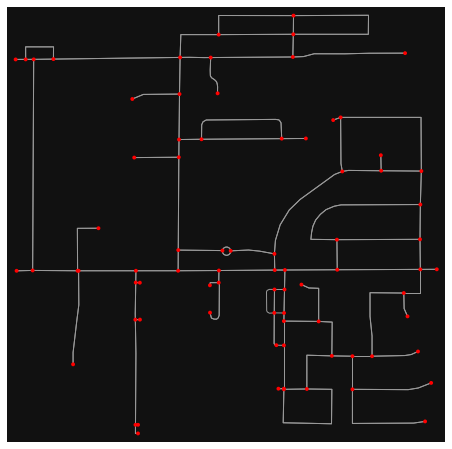

In [36]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

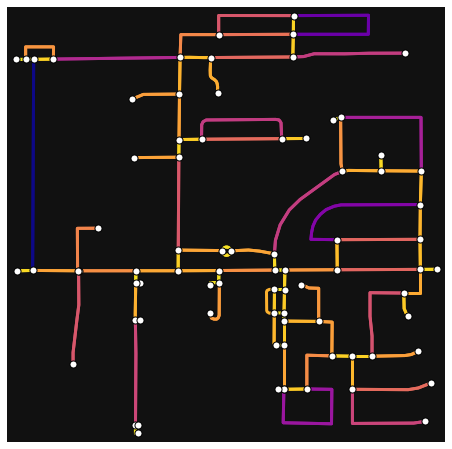

In [37]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

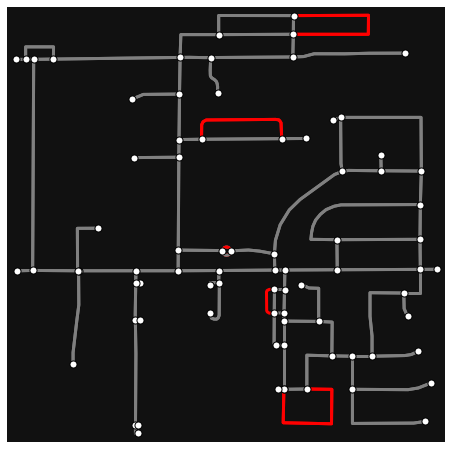

In [38]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

-----------------------------------------------

In [40]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [41]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/network.graphml")

In [42]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

1.1666439307642902